In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores
from fingerprint import FuzzyFingerPrint

In [2]:
receptor = 'CHK1'#AR B2AR CDK2 CHK1 HSP90 LPXC TRMD

data_set_dir = '/scratch/PI/rondror/docking_data/'+receptor+'/'

xrmsd_file = 'xrmsd.csv'
xglide_dir = data_set_dir + 'xglide/'
crystal_fp_file = data_set_dir + '/ifp/crystal_ifp_3/ifp.fp'
xdocking_fp_dir = data_set_dir + '/ifp/xglide_ifp_3/'

In [3]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose).
# Pose -- attributes: rmsd (float), fp (Fingerprint, num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb, feats (dict of residue name:interaction list).

# crystals: maps structures to Poses, 
#           e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides:   maps ligand_struct, grid_struct to Ligands, 
#           e.g., glides['4LDO']['4LDO'] = Ligand(...)

## STEP 1:
## load in the crystal structures, docking results, and fingerprints

(all_xcrystals, all_xglides) = load_data(
    data_set_dir, xrmsd_file, xglide_dir, crystal_fp_file, xdocking_fp_dir,w=[10,10,10,1,0])

Loading crystal structures...
Loading glidescores...
0 of 169 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


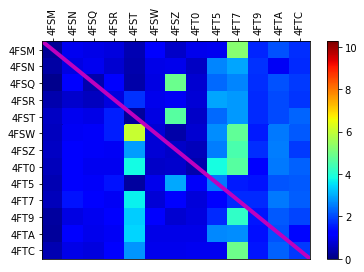

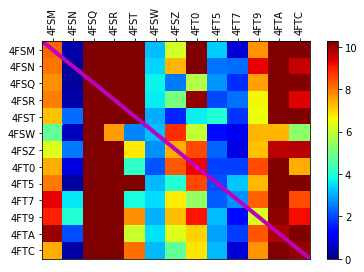

got lucky on 0 of 169 pairs.


In [4]:
## STEP 2:
## visualize docking results

# in the heatmaps, each row is a structure and each column is a ligand

ligs = sorted(all_xglides.keys())#['4LDL','4LDO','4QKX'] # ['3P0G','4LDL','4LDO','4QKX','3PDS']
structs = []
for l in ligs:
    structs.extend([i for i in all_xglides[l] if i not in structs])
structs.sort()

n = 25

xglides = {l:{s:all_xglides[l][s] for s in all_xglides[l] if s in structs} for l in all_xglides if l in ligs}
xcrystals = {s:all_xcrystals[s] for s in all_xcrystals}

#all_poses = refine_poses(xglides, require_fp=False)
#for lig in ligs:
#    xglides[lig]['all'] = Ligand(None)
#    xglides[lig]['all'].poses = {i:all_poses[lig][i] for i in range(len(all_poses[lig]))}
    
#structs.append('all')

get_ipython().magic(u'matplotlib inline')

best_rmsd_matrix = get_docking_stats(ligs, structs, xglides, n, lambda x: np.min(x) if x != [] else np.nan)
heatmap(best_rmsd_matrix, ligs, structs)
#print np.nanmean(best_rmsd_matrix[-1][:])

var_mat = get_docking_stats(ligs, structs, xglides, n, lambda x: np.var(x) if x != [] else np.nan)
heatmap(var_mat, ligs, structs)

helpfully_frozen(ligs, structs, xglides, n)

In [5]:
def print_table(a):
    str1 = '|'
    str2 = '|'
    for i in a.keys():#['min','ave','norm','opt','glide','us']:
        str1 = '{} {} |'.format(str1, i)
        str2 = '{} {} |'.format(str2, str(np.mean(a[i]))[:4])
    
    print str1
    print str2

In [6]:
def plot_docking_output(ligs, struct, xglides, n, gscore=True):
    for lig in ligs:
        print lig

        if struct not in xglides[lig]: 
            print 'struct not found. struct, lig: ', struct, lig
            continue
        poses = xglides[lig][struct].poses
        pnum = [i for i in poses.keys()]
        g1 = [poses[i].gscore for i in poses.keys()]
        rmsd = [poses[i].rmsd for i in poses.keys()]
        if gscore:
            plt.plot(g1[:n], rmsd[:n], '.', markersize=10, label=lig)
        else:
            plt.plot(pnum[:n], rmsd[:n], '.', markersize=10, label=lig)

    #plt.gca().set_ylim([0,12])
    #plt.gca().set_xlim([0,25])
    plt.legend()
    plt.show()

4FT9


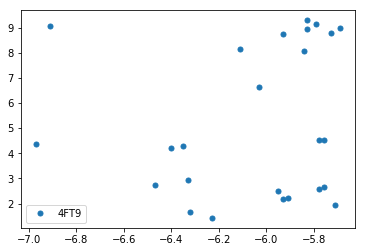

In [7]:
get_ipython().magic(u'matplotlib inline')

# [ligands], struct, glides, num_poses, glidscore=True (if false, plot vs pose_number instead)
plot_docking_output(['4FT9'],'4FTA',xglides,25,True)

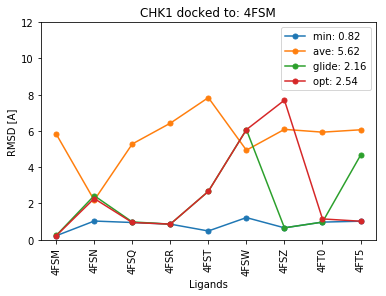

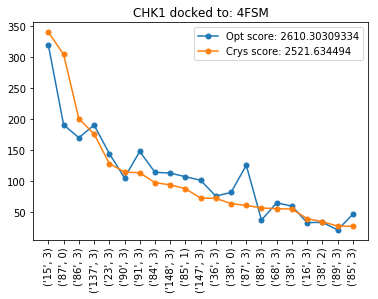

4FSM performance:
| opt | ave | glide | min |
| 2.54 | 5.62 | 2.16 | 0.82 |
average across all data:
| opt | ave | glide | min |
| 2.54 | 5.62 | 2.16 | 0.82 |


In [8]:
## STEP 4:
## score all pairs of ligands
#print glides.keys()
#best_rmsd_matrix = best_pose(glides.keys(), glides.keys(), glides, 50)
#best_rmsd_matrix2 = best_pose(xglides.keys(), xglides.keys(), xglides, 25)

get_ipython().magic(u'matplotlib inline')

def mul_overlap(fp1, fp2, exclude={}):
    score = 0
    for r in fp1.feats:
        if r in fp2.feats:
            if r in exclude:
                for i in [j for j in range(len(fp1.feats[r])) if j not in exclude[r]]:
                    score += fp1.feats[r][i]*fp2.feats[r][i]
            else:
                score += np.dot(fp1.feats[r], fp2.feats[r])
    return score

all_final = {}

for struct in [structs[0]]:#['4FTA']:
    #ignore = ['4FSW','4FSZ','4FT0','4FSQ']
    filt_lig = [l for l in ligs if best_rmsd_matrix[structs.index(struct)][ligs.index(l)] < 1.5]
    #if len(filt_lig) < 10: continue
        
    scores = Scores(xglides, xcrystals, filt_lig, struct, n, mul_overlap)
    title = '{} docked to: {}'.format(receptor, struct)
    final_rmsds = plot_final_rmsds(scores, title)
    #if struct == 'all': continue
    
    crystal_cluster = {(l, -1):xcrystals[l].fp for l in filt_lig}
    opt_cluster = [(l,p) for (l,p) in scores.optimized_scores.items()]
    opt_cluster = {(l,p):xglides[l][struct].poses[p].fp for (l,p) in opt_cluster}
    plot_shared_interactions(crystal_cluster, c2=opt_cluster, max_r=20,
                             lab1='Crys', lab2='Opt', title=title,interactions=[0,1,2,3])
    
    #print opt_cluster.keys()
    
    a = scores.all_analysis
    print struct, 'performance:'
    print_table({i:a[i][1][:] for i in a})
    for i in a:
        if i not in all_final: all_final[i] = []
        all_final[i].extend(a[i][1][:])

print 'average across all data:'
print_table(all_final)